In [2]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
############################################
path = 'my_data'
testRatio = 0.2
valRatio = 0.2
imageDimensions = (32, 32, 3)
batchSizeVal = 500
epochsVal = 10 # 0-9 | A-Z, a-z, 0-9, ?!çÇ"'[]().,
stepsPerEpoch = 2000
############################################
images = []    # LIST CONTAINING ALL THE IMAGES
classNo = []   # LIST CONTAINING ALL THE CORRESPONDING CLASS ID OF IMAGES
numOfSamples = []
count = 0
############################################

In [4]:
myList = os.listdir(path)
print("Total Classes Detected", len(myList))
noOfClasses = len(myList)

Total Classes Detected 10


In [5]:
print("Importing Classes .......")
for x in range(0, noOfClasses):
    myPicList = os.listdir(path + "/" + str(x))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(x) + "/" + str(y))
        curImg = cv2.resize(curImg, (imageDimensions[0], imageDimensions[1]))
        images.append(curImg)
        classNo.append(x)
    print(x, end=" ")

print(" ")
print("Total Images in Images List = ", len(images))
print("Total IDS in classNo List = ", len(classNo))

Importing Classes .......
01 23 456 789  
Total Images in Images List =  10160
Total IDS in classNo List =  10160


In [6]:
#### CONVERT TO NUMPY ARRAY
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)

(10160, 32, 32, 3)


In [7]:
##### Spliting the data
x_train, x_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=testRatio)

print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)

(6502, 32, 32, 3)
(2032, 32, 32, 3)
(1626, 32, 32, 3)


In [8]:
#### PLOT BAR CHART FOR DISTRIBUTION OF IMAGES
for x in range(0, noOfClasses):
    #print(len(np.where(y_train==x)[0]))
    numOfSamples.append(len(np.where(y_train == x)[0]))

print(numOfSamples)

[624, 670, 652, 644, 649, 662, 644, 643, 680, 634]


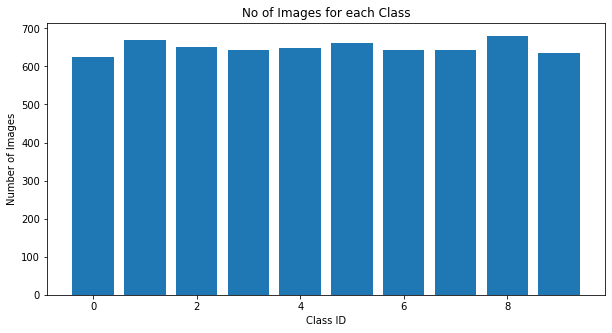

In [9]:
plt.figure(figsize=(10, 5))
plt.bar(range(0, noOfClasses), numOfSamples)
plt.title("No of Images for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

In [10]:
#### PREPOSSESSING FUNCTION FOR IMAGES FOR TRAINING
def preProcessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

# img = preProcessing(x_train[30])
# img = cv2.resize(img, (300, 300))
# cv2.imshow("PreProcessing", img)
# cv2.waitKey(0)

In [11]:
x_train = np.array(list(map(preProcessing, x_train)))
x_test = np.array(list(map(preProcessing, x_test)))
x_validation = np.array(list(map(preProcessing, x_validation)))


In [12]:
#### RESHAPE IMAGES
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_validation = x_validation.reshape(x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1)


In [13]:
#### IMAGE AUGMENTATION
dataGem = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)

dataGem.fit(x_train)

In [14]:
#### ONE HOT ENCODING OF MATRICES
y_train = to_categorical(y_train, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)

In [21]:
#### CREATING THE MODEL
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5, 5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2, 2)
    noOfNode = 500

    model = Sequential()
    model.add((Conv2D(noOfFilters,
                      sizeOfFilter1,
                      input_shape=(imageDimensions[0],
                                   imageDimensions[1],
                                   1),
                      activation='relu')))
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(noOfNode, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))
    optimizer = Adam(lr=0.001)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [22]:
model = myModel()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 30)         

In [24]:
#### STARTING THE TRAINING PROCESS
history = model.fit_generator(dataGem.flow(x_train,
                                           y_train,
                                           batch_size=batchSizeVal),
                              steps_per_epoch=stepsPerEpoch,
                              epochs=epochsVal,
                              validation_data=(x_validation, y_validation),
                              shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 803s 401ms/step - loss: 0.0782 - accuracy: 0.9759 - val_loss: 0.0153 - val_accuracy: 0.9969
Epoch 2/10
2000/2000 [==============================] - 759s 380ms/step - loss: 0.0582 - accuracy: 0.9822 - val_loss: 0.0150 - val_accuracy: 0.9938
Epoch 3/10
2000/2000 [==============================] - 664s 332ms/step - loss: 0.0439 - accuracy: 0.9866 - val_loss: 0.0123 - val_accuracy: 0.9957
Epoch 4/10
2000/2000 [==============================] - 670s 335ms/step - loss: 0.0330 - accuracy: 0.9895 - val_loss: 0.0257 - val_accuracy: 0.9951
Epoch 5/10
2000/2000 [==============================] - 588s 294ms/step - loss: 0.0291 - accuracy: 0.9909 - val_loss: 0.0086 - val_accuracy: 0.9975
Epoch 6/10
2000/2000 [==============================] - 650s 325ms/step - loss: 0.0277 - accuracy: 0.9916 - val_loss: 0.0121 - val_accuracy: 0.9957
Epoch 7/10
2000/2000 [==============================] - 585s 292ms/step - loss: 0.0267 - accuracy: 0.9922 - val_

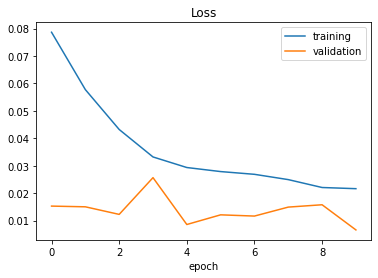

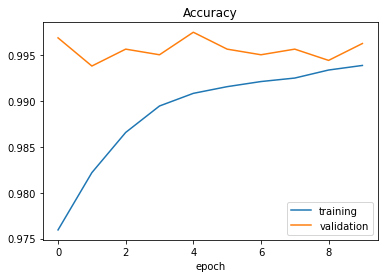

In [25]:
#### PLOT THE RESULTS
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [26]:
#### EVALUATE USING TEST IMAGES
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Score = ', score[0])
print('Test Accuracy =', score[1])

Test Score =  0.0067259084828032
Test Accuracy = 0.9965550899505615


In [28]:
#### SAVE THE TRAINED MODEL
pickle_out = open("model_trained_t.p", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()